In [1]:
from scipy.integrate import quad

import TMQGP as tm
from numpy import *

import QuarkTM

import matplotlib
matplotlib.style.use('publication23')

mQ = 0.6

tm.Efirst_k_integral

qrange = linspace(0, 5, 151)
erange = linspace(-5, 5, 401)

pt = QuarkTM.Particle(mQ, qrange, erange, eps=5e-2)
T = 0.2
ch = QuarkTM.Channel(pt, pt, T, G=6, screen=0)

## Check the 2-particle propagator

In [2]:
def delta(e, e0, eps=1e-2):
    return -1/pi * imag(1 / (e - e0 + eps*1j))

In [3]:
def f(x, T):
    return 1 / (exp(x/ T) + 1)

In [4]:
ImG2_an = -pi*(1 - f(pt.om0(0), T) - f(erange - pt.om0(0), T)) * delta(erange, 2*pt.om0(0), eps=2*pt.eps)

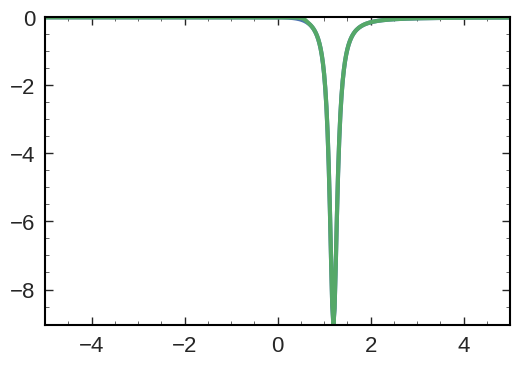

In [5]:
plt.plot(erange, ImG2_an)
plt.plot(erange, imag(ch.G2[:, 0]))

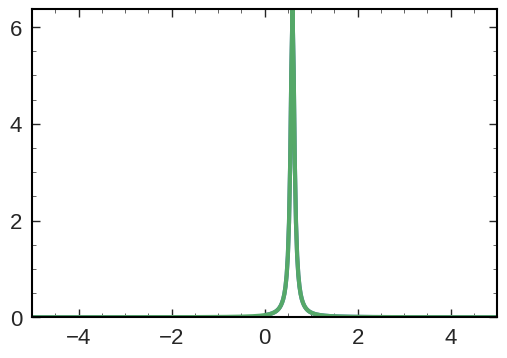

In [6]:
plt.plot(erange, -1/pi*imag(pt.G0(erange, 0)))
plt.plot(erange, delta(erange, pt.om0(0), eps=pt.eps))

## Check the T-matrix solution in the case of no pole

In [7]:
ch.populate_T()

In [8]:
k0 = nan_to_num(sqrt(erange**2/4 - mQ**2)) * (erange/2 > mQ)

/tmp/ipykernel_52375/1595745807.py:1: RuntimeWarning: invalid value encountered in sqrt
  k0 = nan_to_num(sqrt(erange**2/4 - mQ**2)) * (erange/2 > mQ)


In [9]:
ImX_an = pi/pi * k0**2 * ch.v(k0)**2 * (1 - 2*f(erange/2, T))

What about the real part of $X(E)$?

In [10]:
iImX = interp1d(erange, ImX_an, kind='cubic', bounds_error=0, fill_value=0)

In [11]:
iImX(0.4)

array(-1.48657718e-33)

In [12]:
ReX = array([quad(lambda z: iImX(z), -5.1, 5.1, weight='cauchy', wvar=e)[0]/pi for e in erange])

/tmp/ipykernel_52375/2942079955.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  ReX = array([quad(lambda z: iImX(z), -5.1, 5.1, weight='cauchy', wvar=e)[0]/pi for e in erange])


Plot it:

In [13]:
iImG2 = tm.InterDenom2D()

Text(0.5, 0, 'E [GeV]')

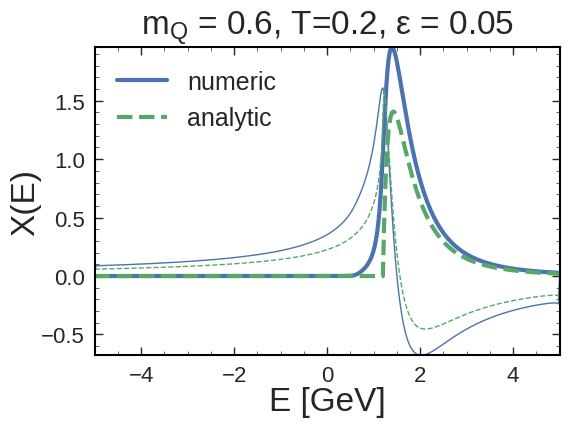

In [14]:
l_num, = plt.plot(erange, imag(ch.XS[0][:, 0]), label='numeric')
plt.plot(erange, real(ch.XS[0][:, 0]), lw=1, c=l_num.get_c())
l_an, = plt.plot(erange, ImX_an, label='analytic', ls='--')
plt.plot(erange, ReX, lw=1, c=l_an.get_c(), ls='--')

plt.legend()
plt.title(rf'$m_Q$ = {mQ}, T={T}, $\varepsilon$ = {pt.eps}')

plt.ylabel("X(E)")
plt.xlabel('E [GeV]')

# plt.ylim(-0.01, 0.01)
# plt.savefig('X_E.pdf', bbox_inches='tight')

In [15]:
T = 0.16

In [16]:
TM_an = array([-4*pi*ch.v(q)**2 / (1 - (real(ch.XS[0][:, 0]) + 1j*imag(ch.XS[0][:, 0]))) for q in qrange]).transpose()

In [17]:
TM_an = array([-4*pi*ch.v(q)**2 / (1 - (ReX + 1j*(ImX_an+0.001))) for q in qrange]).transpose()

In [18]:
TM_an.shape

(401, 151)

In [19]:
ch.TM.shape

(401, 151)

Text(0.5, 0, 'E [GeV]')

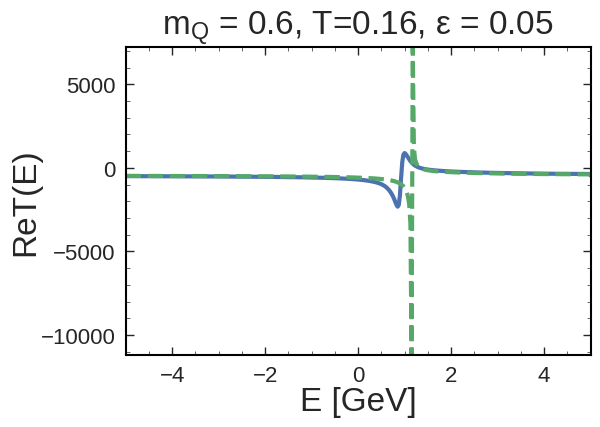

In [20]:
plt.plot(erange, real(ch.TM[:, 0]))
plt.plot(erange, real(TM_an[:, 0]), ls='--')
plt.title(rf'$m_Q$ = {mQ}, T={T}, $\varepsilon$ = {pt.eps}')

plt.ylabel("ReT(E)")
plt.xlabel('E [GeV]')

# plt.ylim(-0.01, 0.01)
# plt.savefig('ReT_E.pdf', bbox_inches='tight')

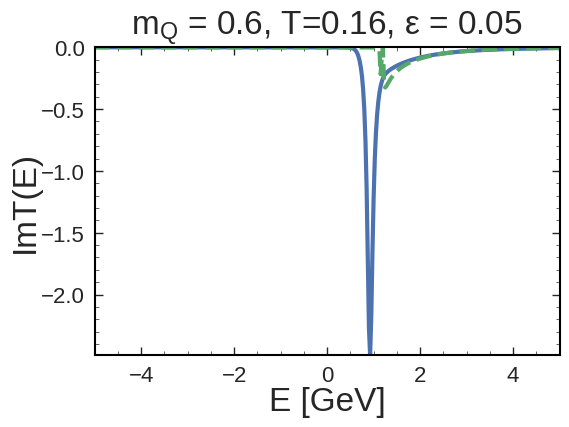

In [21]:
plt.plot(erange, imag(ch.TM[:, 50]))
plt.plot(erange, imag(TM_an[:, 50]), ls='--')

plt.title(rf'$m_Q$ = {mQ}, T={T}, $\varepsilon$ = {pt.eps}')

plt.ylabel("ImT(E)")
plt.xlabel('E [GeV]')

# plt.ylim(-0.01, 0.01)
plt.savefig('ImT_E.pdf', bbox_inches='tight')

In [22]:
iImTM_an = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(ch.TM)))
iReTM_an = tm.Interpolator2D(qrange, erange, ascontiguousarray(real(ch.TM)))

In [23]:
# iImTM_an = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(TM_an)))
# iReTM_an = tm.Interpolator2D(qrange, erange, ascontiguousarray(real(TM_an)))

In [24]:
def Sigma_x_integrand(om, q, p, x):
    s = (pt.om0(q) + pt.om0(p))**2 - (p**2 + q**2 + 2*p*q*x)
    q_cm2 = 1 / s * ((s - mQ**2 - mQ**2)**2/4 - mQ**2 * mQ**2)
    # print(q_cm2)
    if q_cm2 < 0:
        return 0

    Ecm = (om + pt.om0(p))**2 - (p**2 + q**2 + 2*p*q*x)
    # print(Ecm)
    if Ecm < 0:
        return 0
    Ecm = sqrt(Ecm)
    d = om + pt.om0(p)
    # print(iImTM_an(sqrt(q_cm2), Ecm), p)
    res =  iImTM_an(sqrt(q_cm2), sign(d)*Ecm)
    # print(res)
    return res

In [25]:
def ReSigma_x_integrand(om, q, p, x):
    s = (pt.om0(q) + pt.om0(p))**2 - (p**2 + q**2 + 2*p*q*x)
    q_cm2 = 1 / s * ((s - mQ**2 - mQ**2)**2/4 - mQ**2 * mQ**2)
    # print(q_cm2)
    if q_cm2 < 0:
        return 0

    Ecm = (om + pt.om0(p))**2 - (p**2 + q**2 + 2*p*q*x)
    # print(Ecm)
    if Ecm < 0:
        return 0
    Ecm = sqrt(Ecm)
    # print(iImTM_an(sqrt(q_cm2), Ecm), p)
    d = om + pt.om0(p)
    res =  iReTM_an(sqrt(q_cm2), (sign(d)*Ecm))
    # print(res)
    return res

In [26]:
iEps = tm.Interpolator(qrange, pt.om0(qrange), 'cubic')

In [27]:
def Sigma_int_x(om, q, p):
    return quad(lambda z: Sigma_x_integrand(om, q, p, z), -1, 1)[0]

In [28]:
def ReSigma_int_x(om, q, p):
    return quad(lambda z: ReSigma_x_integrand(om, q, p, z), -1, 1)[0]

In [29]:
def g(x, T):
    return 1/(exp(x/T) - 1)

#### Check the integrand

#### Check the integral

In [30]:
def ImSigma(om, q):
    return quad(lambda z: z**2/4/pi**2 * Sigma_int_x(om, q, z) * (f(pt.om0(z), T) + g(pt.om0(z) + om, T)), 0, 5)[0]

In [31]:
def ReSigma(om, q):
    return quad(lambda z: z**2/4/pi**2 * ReSigma_int_x(om, q, z) * (f(pt.om0(z), T) + g(pt.om0(z) + om, T)), 0, 5)[0]

In [32]:
# ims = array([ImSigma(z, 0) for z in erange])

In [33]:
# res = array([ReSigma(z, 0) for z in erange])

In [34]:
# # plt.plot(erange, -ims)
# plt.plot(erange, -int3)
# # plt.plot(erange, res, ls='--')
# # plt.semilogy()
# plt.ylim(0, 1)
# plt.semilogy()
# plt.ylim(1e-6, 1)

In [35]:
ims2 = array([tm.Efirst_k_integral(e, 0, T, iImTM_an, pt.R, iEps, iEps, 0, 0) for e in erange])

In [36]:
ims3 = array([tm.sigma_ff_onshell(e, 0, T, iImTM_an, pt.R, iEps, iEps, 0) for e in erange])

In [37]:
ims4 = array([tm.sigma_ff_onshell(e, 0, T, iImTM_an, pt.R, iEps, iEps, 0) for e in erange])

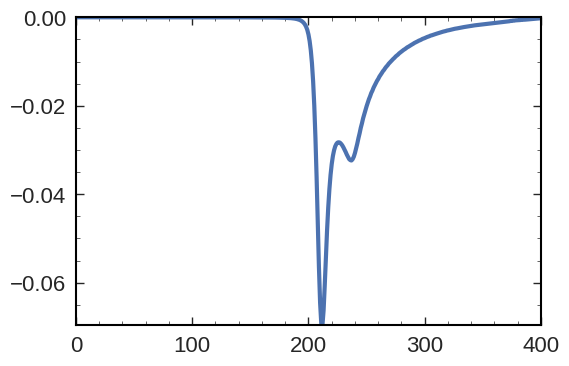

In [38]:
plt.plot(ims2)

In [39]:
ims_kfirst = array([tm.Efirst_kfirst_x(e, 0, T, iImTM_an, pt.R, iEps, iEps, 0, 0) for e in erange])

(0.0, 3.0)

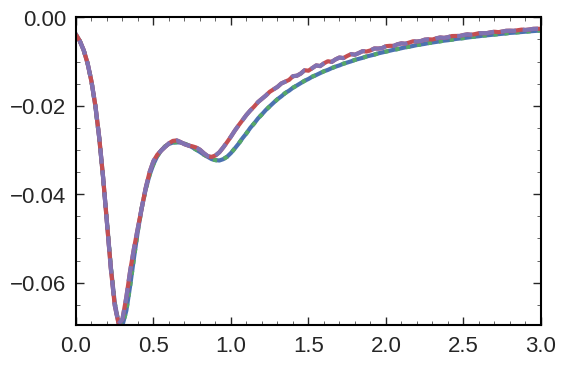

In [40]:
# plt.plot(erange, ims)
plt.plot(erange, ims2)
plt.plot(erange, ims_kfirst, ls=':')

plt.plot(erange, ims3, ls='-')
plt.plot(erange, ims4, ls='--')
# plt.plot(erange, ims, ls=':')

plt.xlim(0, 3)

#### Compare integrands from `C++` code

In [42]:
int1 = array([tm.x_cm_onshell_integrand2(0, e, 1, 0, 0.5, T, iImTM_an, pt.R, iEps, iEps, 0, 0) for e in erange])

In [43]:
int2 = array([tm.Efirst_cm_onshell_integrand(e, 1, 0, 0.5, 0, T, iImTM_an, pt.R, iEps, iEps, 0, 0) for e in erange])

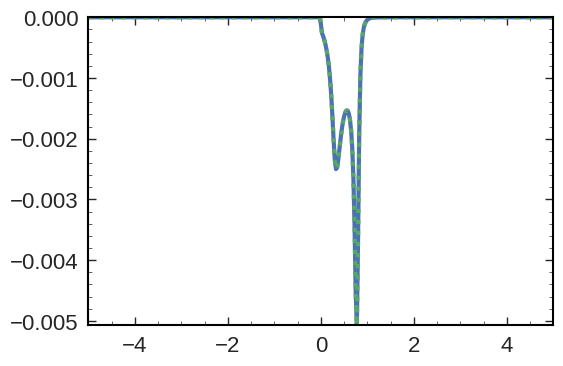

In [44]:
plt.plot(erange, int1)
plt.plot(erange, int2, ls=':')